#  实战：基于Opencv的车牌识别 

- 1. 车牌检测：第一步是从汽车上检测车牌所在位置。我们将使用OpenCV中矩形的轮廓检测来寻找车牌。如果我们知道车牌的确切尺寸，颜色和大致位置，则可以提高准确性。通常，也会将根据摄像机的位置和该特定国家/地区所使用的车牌类型来训练检测算法。但是图像可能并没有汽车的存在，在这种情况下我们将先进行汽车的，然后是车牌。

- 2. 字符分割：检测到车牌后，我们必须将其裁剪并保存为新图像。同样，这可以使用OpenCV来完成。

- 3. 字符识别：现在，我们在上一步中获得的新图像肯定可以写上一些字符（数字/字母）。因此，我们可以对其执行OCR（光学字符识别）以检测数字 


## 1. 车牌检测 
**第1步： 将图像调整为所需大小，然后将其灰度** 

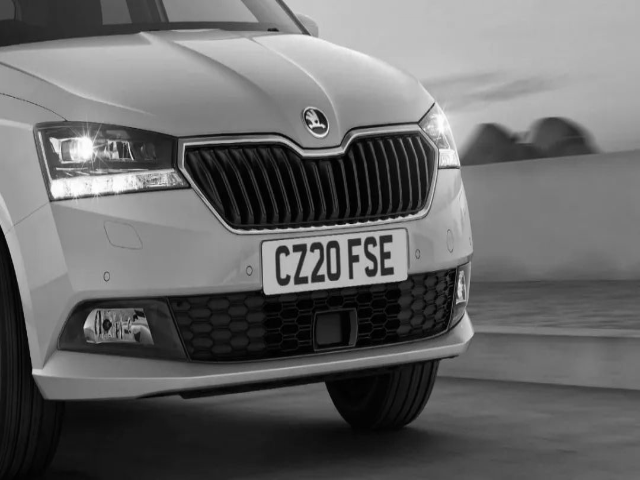

In [1]:
import cv2  
import numpy as np 
from PIL import Image
import pytesseract

img = cv2.imread('./images/car.jpg',1)
img = cv2.resize(img, (640,480) ) 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
Image.fromarray(gray)

**步骤2**：每张图片都会包含有用和无用的信息，在这种情况下，对于我们来说，只有牌照是有用的信息，其余的对于我们的程序几乎是无用的。这种无用的信息称为噪声。通常，使用**双边滤波（模糊）会从图像中删除不需要的细节**

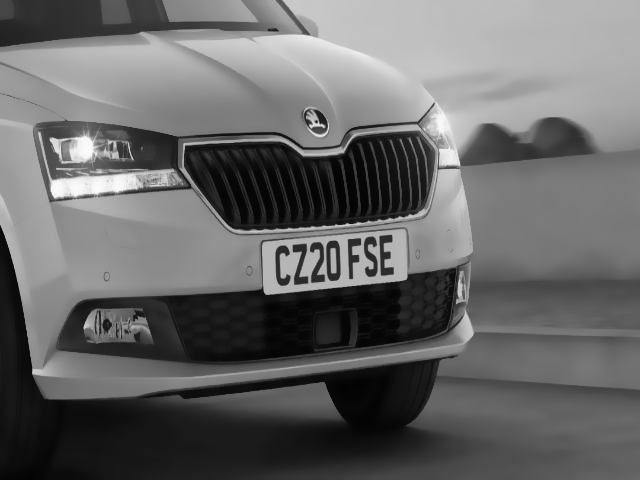

In [2]:
gray = cv2.bilateralFilter(gray, 13, 15, 15) 
Image.fromarray(gray)

**步骤3**：下一步是我们执行**边缘检测**的有趣步骤。有很多方法可以做到，最简单和流行的方法是使用**OpenCV中的canny edge方法**。执行相同操作的行如下所示

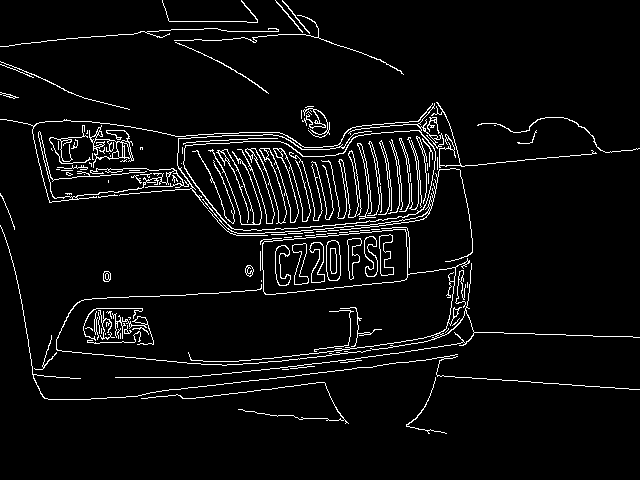

In [3]:
edged = cv2.Canny(gray, 30, 200) #Perform Edge detection 
Image.fromarray(edged)

**步骤4**：现在我们可以开始在图像上**寻找轮廓**

In [4]:
contours, hierarchy =cv2.findContours(edged.copy(),cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours,key=cv2.contourArea, reverse = True)[:10]
screenCnt = None

**一旦检测到计数器，我们就将它们从大到小进行排序**，并只考虑前10个结果而忽略其他结果。在我们的图像中，计数器可以是具有闭合表面的任何事物，但是在所有获得的结果中，牌照号码也将存在，因为它也是闭合表面。

为了过滤获得的结果中的车牌图像，我们将遍历所有结果，并检查其具有四个侧面和闭合图形的矩形轮廓。由于车牌肯定是四边形的矩形。

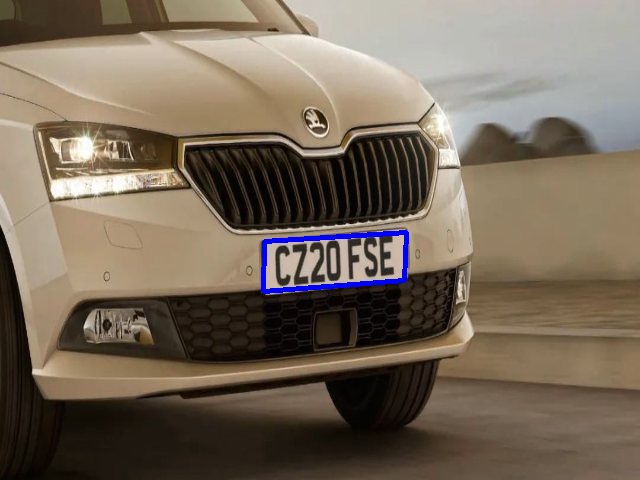

In [5]:
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
 
    if len(approx) == 4:
        screenCnt = approx
        break 
        
if screenCnt is None:
    detected = 0
    print ("No contour detected")
else:
     detected = 1

if detected == 1:
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)

    
Image.fromarray(img)

**步骤5**：现在我们知道车牌在哪里，剩下的信息对我们来说几乎没有用。因此，我们可以对**整个图片进行遮罩，除了车牌所在的地方**。相同的代码如下所示

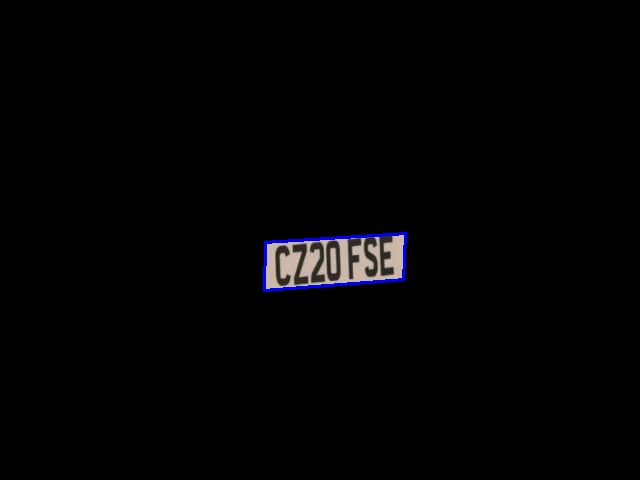

In [6]:
# Masking the part other than the number plate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(img,img,mask=mask)
Image.fromarray(new_image)

## 2. 字符分割 
车牌识别的下一步是通过裁剪车牌并将其保存为新图像，将车牌从图像中分割出来。然后，我们可以使用此图像来检测其中的字符。下面显示了从主图像裁剪出ROI（感兴趣区域）图像的代码

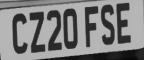

In [7]:
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1] 
Image.fromarray(Cropped)

## 3. 字符识别 

该车牌识别的最后一步是从分割的图像中实际读取车牌信息。就像前面的教程一样，我们将使用pytesseract包从图像读取字符。

pytesseract配置教程:https://blog.csdn.net/Castlehe/article/details/118751833

In [10]:
pytesseract.pytesseract.tesseract_cmd = r'D:\Program Files\Tesseract-OCR\tesseract.exe'

In [11]:
text = pytesseract.image_to_string(Cropped, config='--psm 11')
print("programming_fever's License Plate Recognition\n")
print("Detected license plate Number is:",text)


programming_fever's License Plate Recognition

Detected license plate Number is: CZ20FSE

